In [1]:
import numpy as np
import pandas as pd
from scipy.io import mmread
from scipy import sparse

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)

import anndata as ad

# Import from maxfuse package
# from maxfuse import Mario
# from maxfuse.mario.match import pipelined_mario

import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

## Step 1: Load and Preprocess Protein Data

The CProtein data is exported from QuPath as a TSV file with cell measurements.
We extract:
- Cell centroids (X, Y coordinates)
- Mean protein intensities for each marker

In [9]:
protein_adata_raw = ad.read_h5ad('data/6551_qupath_raw_export.h5ad')
print(f"Phenocycler data shape: {protein_adata_raw.shape}")

Phenocycler data shape: (1900754, 59)


In [10]:
protein_adata_raw.var_names

Index(['DAPI', 'IAPP', 'CD107a', 'CD4', 'CD31', 'SMA', 'CD68', 'CD44',
       'Vimentin', 'CD99', 'E-cadherin', 'IDO1', 'CD66', 'INS', 'Ker8-18',
       'CD11c', 'CD38', 'HLA-DR', 'CD34', 'iNOS', 'M2Gal3', 'B3TUBB', 'CD8',
       'PCNA', 'FOXP3', 'CD57', 'Ki67', 'Granzyme B', 'HLA-A', 'CD20',
       'Collagen IV', 'VISTA', 'Pan-Cytokeratin', 'PD-1', 'LAG3', 'SST',
       'TCF-1', 'TOX', 'Caveolin', 'ICOS', 'CD163', 'EpCAM', 'PD-L1', 'CD79a',
       'Keratin 5', 'CD3e', 'GCG', 'Beta-actin', 'Bcl-2', 'MPO', 'CD56',
       'CD39', 'Iba1', 'SOX2', 'CD209', 'Podoplanin', 'CD11b', 'CD206',
       'TP63'],
      dtype='object')

In [11]:
protein_adata = protein_adata_raw[:, ['CD107a', 'CD4',  'CD66',
        'CD38',  'CD8',  'HLA-DR',
       'PCNA', 'FOXP3', 'CD57', 'Ki67', 'CD20', 'Granzyme B', 
       'VISTA', 'PD-1', 'CD56', 'CD79a',
       'TCF-1', 'TOX', 'PD-L1', 
       'CD3e', 'Bcl-2', 'CD39'
       ]]

In [12]:
def assign_tissue_by_parent(parent):
    """Assign tissue type based on Parent annotation from QuPath."""
    if pd.isna(parent):
        return 'Unknown'
    elif 'Tissue_LN' in str(parent):
        return 'pLN'
    elif 'Tissue' in str(parent) or 'Islet' in str(parent):
        return 'Pancreas'
    else:
        return 'Unknown'

# Assign tissue labels
protein_adata.obs['Tissue'] = protein_adata.obs['Parent'].apply(assign_tissue_by_parent)
print("Tissue distribution before filtering:")
print(protein_adata.obs['Tissue'].value_counts())

# Filter to keep only cells with valid tissue assignments (Pancreas or pLN)
valid_tissues = ['Pancreas', 'pLN']
tissue_mask = protein_adata.obs['Tissue'].isin(valid_tissues)
n_before = protein_adata.n_obs
protein_adata = protein_adata[tissue_mask].copy()
n_after = protein_adata.n_obs

print(f"\nFiltered out {n_before - n_after:,} cells with unknown tissue assignment")
print(f"Remaining cells: {n_after:,}")
print("\nTissue distribution after filtering:")
print(protein_adata.obs['Tissue'].value_counts())

Tissue distribution before filtering:
Tissue
Pancreas    1757054
Unknown       87484
pLN           56216
Name: count, dtype: int64

Filtered out 87,484 cells with unknown tissue assignment
Remaining cells: 1,813,270

Tissue distribution after filtering:
Tissue
Pancreas    1757054
pLN           56216
Name: count, dtype: int64


## Step 1a: 

In [13]:
protein_adata

AnnData object with n_obs × n_vars = 1813270 × 22
    obs: 'Object ID', 'Classification', 'Parent', 'X_centroid', 'Y_centroid', 'Cell_Area', 'Cell_Length', 'Cell_Circularity', 'Cell_Solidity', 'Cell_Max_diameter', 'Cell_Min_diameter', 'SignedDistanceIslet', 'SignedDistanceIsletExpanded', 'SignedDistanceTissue_LN', 'SignedDistanceTissue_Panc', 'Tissue'

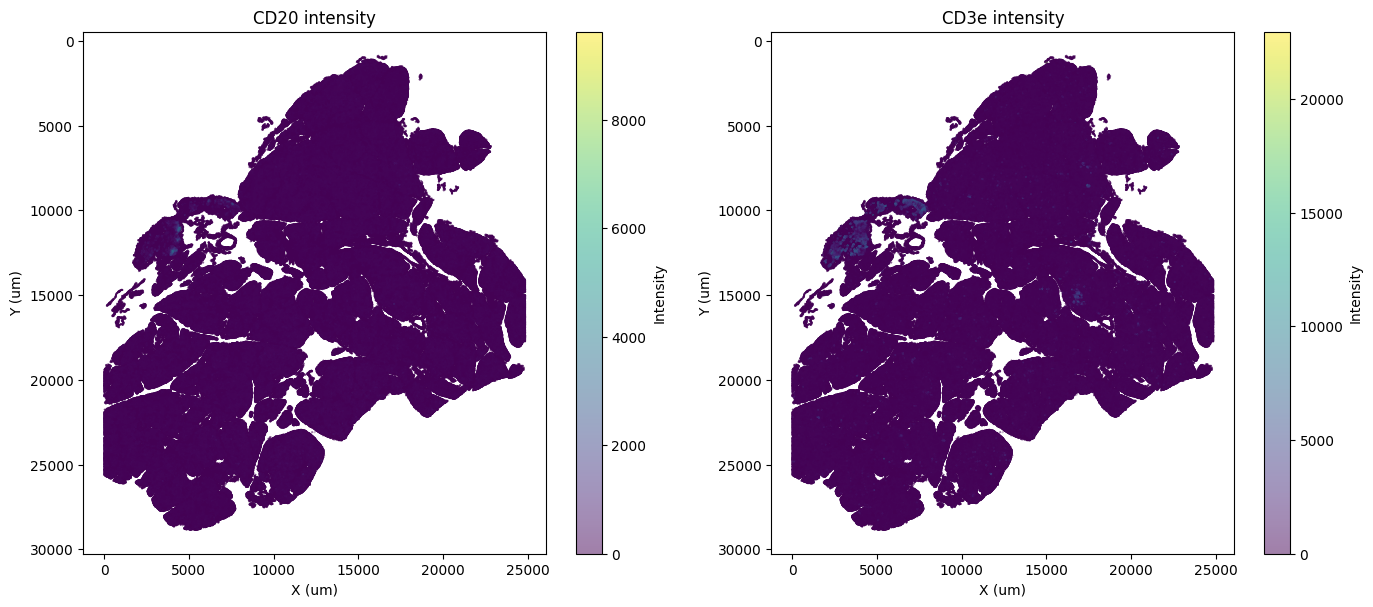

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cd20_idx = protein_adata.var_names.get_loc('CD20') if 'CD20' in protein_adata.var_names else 0
scatter = axes[0].scatter(protein_adata.obs['X_centroid'], protein_adata.obs['Y_centroid'], c=protein_adata.X[:, cd20_idx], 
                          s=0.1, alpha=0.5, cmap='viridis')
axes[0].set_xlabel('X (um)')
axes[0].set_ylabel('Y (um)')
axes[0].set_title(f'{protein_adata.var_names[cd20_idx]} intensity')
axes[0].set_aspect('equal')
axes[0].invert_yaxis()
plt.colorbar(scatter, ax=axes[0], label='Intensity')

cd3_idx = protein_adata.var_names.get_loc('CD3e') if 'CD3e' in protein_adata.var_names else 0
scatter = axes[1].scatter(protein_adata.obs['X_centroid'], protein_adata.obs['Y_centroid'], c=protein_adata.X[:, cd3_idx], 
                          s=0.1, alpha=0.5, cmap='viridis')
axes[1].set_xlabel('X (um)')
axes[1].set_ylabel('Y (um)')
axes[1].set_title(f'{protein_adata.var_names[cd3_idx]} intensity')
axes[1].set_aspect('equal')
plt.colorbar(scatter, ax=axes[1], label='Intensity')
axes[1].invert_yaxis()
plt.tight_layout()
plt.show()

In [9]:
morphology_cols = [c for c in protein_adata.obs if 'Area' in c or 'Perimeter' in c or 
                   'Circularity' in c or 'Solidity' in c or 'Eccentricity' in c]
intensity_cols = [c for c in protein_adata.var if 'Mean' in c or 'Median' in c or 'Max' in c]
location_cols = [c for c in protein_adata.obs if 'Centroid' in c or 'centroid' in c]

print(f"\nMorphology columns ({len(morphology_cols)}):")
for c in morphology_cols[:10]:
    print(f"  {c}")
if len(morphology_cols) > 10:
    print(f"  ... and {len(morphology_cols)-10} more")

print(f"\nKey morphology stats:")
if 'Cell_Area' in protein_adata.obs:
    area = protein_adata.obs['Cell_Area']
    print(f"  Cell Area: {area.min():.1f} - {area.max():.1f} µm² (median: {area.median():.1f})")
if 'Cell_Solidity' in protein_adata.obs:
    cell_sol = protein_adata.obs['Cell_Solidity']
    print(f"  Cell Solidity: {cell_sol.min():.1f} - {cell_sol.max():.1f} (median: {cell_sol.median():.1f})")
if 'Cell_Circularity' in protein_adata.obs:
    circ = protein_adata.obs['Cell_Circularity']
    print(f"  Circularity: {circ.min():.2f} - {circ.max():.2f} (median: {circ.median():.2f})")


Morphology columns (3):
  Cell_Area
  Cell_Circularity
  Cell_Solidity

Key morphology stats:
  Cell Area: 0.2 - 453.2 µm² (median: 62.5)
  Cell Solidity: 0.3 - 1.0 (median: 0.9)
  Circularity: 0.10 - 0.79 (median: 0.52)


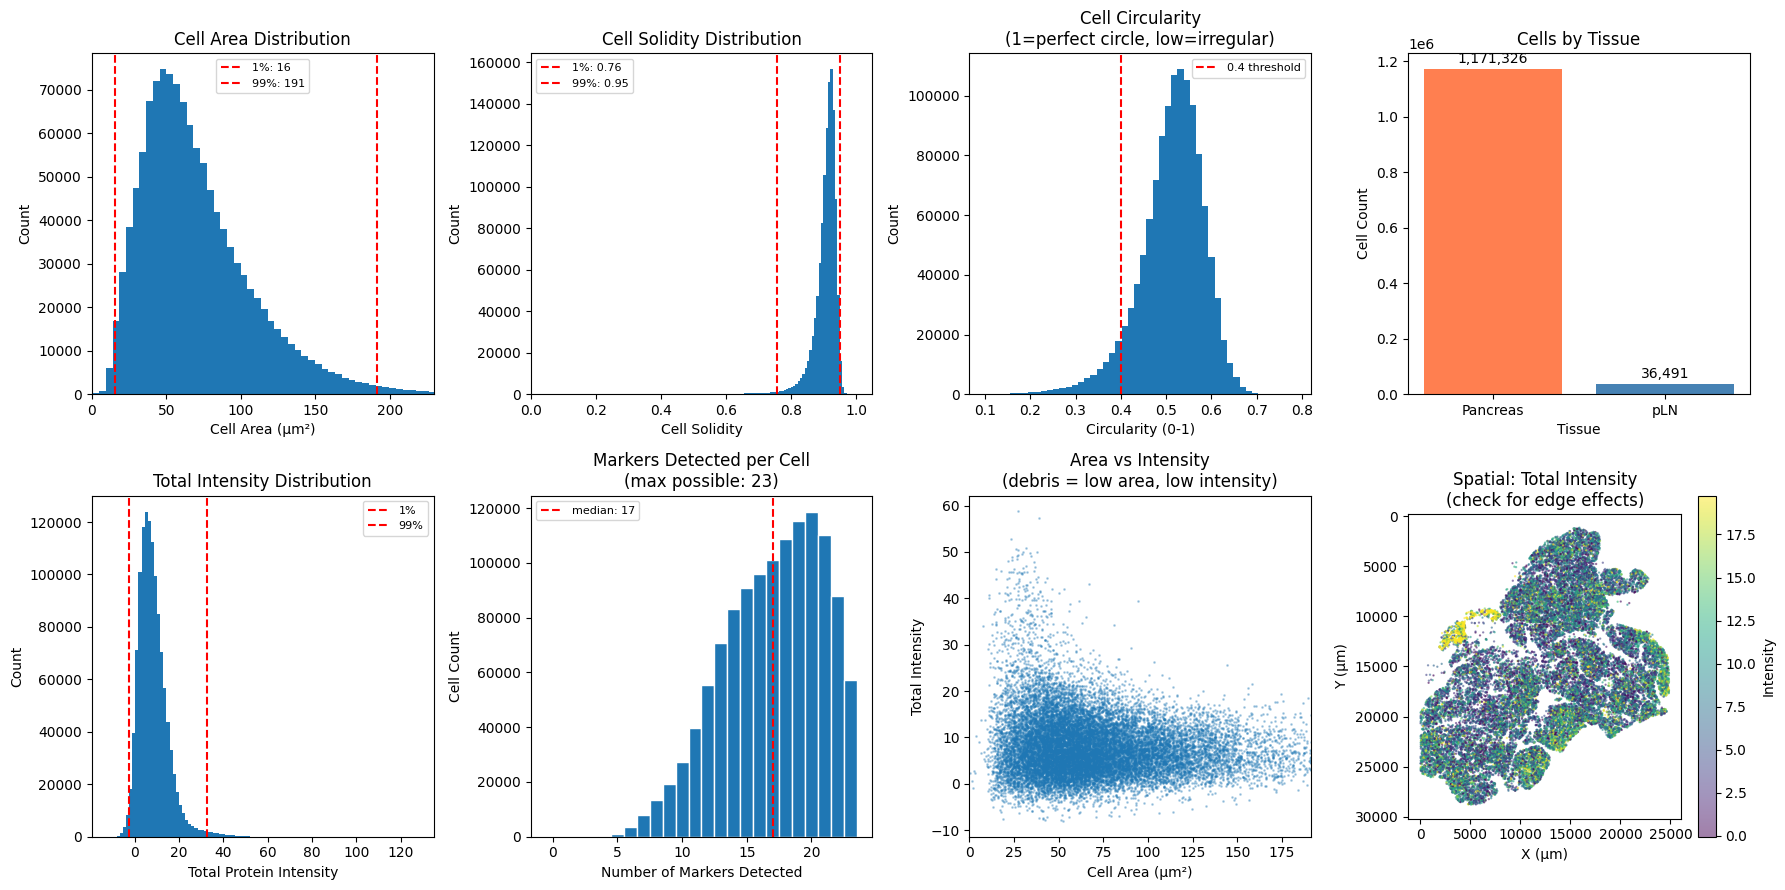


PROTEIN DATA QC SUMMARY
Total cells: 1,207,817

Suggested filters (adjust based on plots above):
  Cell Area: 16 - 191 µm²
  Circularity: > 0.3-0.4 (remove irregular shapes)
  Total Intensity: > -2.8 (remove debris)


In [10]:
# Visualize protein QC metrics for filtering
fig, axes = plt.subplots(2, 4, figsize=(18, 9))

# Row 1: Morphology distributions
# Cell Area
if 'Cell_Area' in protein_adata.obs:
    area = protein_adata.obs['Cell_Area']
    axes[0, 0].hist(area, bins=100, edgecolor='none')
    axes[0, 0].set_xlabel('Cell Area (µm²)')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title('Cell Area Distribution')
    axes[0, 0].axvline(x=area.quantile(0.01), color='r', linestyle='--', label=f'1%: {area.quantile(0.01):.0f}')
    axes[0, 0].axvline(x=area.quantile(0.99), color='r', linestyle='--', label=f'99%: {area.quantile(0.99):.0f}')
    axes[0, 0].legend(fontsize=8)
    axes[0, 0].set_xlim(0, area.quantile(0.99)*1.2)

# Cell Solidity
if 'Cell_Solidity' in protein_adata.obs:
    cell_sol = protein_adata.obs['Cell_Solidity']
    axes[0, 1].hist(cell_sol, bins=100, edgecolor='none')
    axes[0, 1].set_xlabel('Cell Solidity')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_title('Cell Solidity Distribution')
    axes[0, 1].axvline(x=cell_sol.quantile(0.01), color='r', linestyle='--', label=f'1%: {cell_sol.quantile(0.01):.2f}')
    axes[0, 1].axvline(x=cell_sol.quantile(0.99), color='r', linestyle='--', label=f'99%: {cell_sol.quantile(0.99):.2f}')
    axes[0, 1].legend(fontsize=8)
    axes[0, 1].set_xlim(0, 1.05)

# Circularity
if 'Cell_Circularity' in protein_adata.obs:
    circ = protein_adata.obs['Cell_Circularity']
    axes[0, 2].hist(circ, bins=50, edgecolor='none')
    axes[0, 2].set_xlabel('Circularity (0-1)')
    axes[0, 2].set_ylabel('Count')
    axes[0, 2].set_title('Cell Circularity\n(1=perfect circle, low=irregular)')
    axes[0, 2].axvline(x=0.4, color='r', linestyle='--', label='0.4 threshold')
    axes[0, 2].legend(fontsize=8)

# Tissue distribution (was empty)
tissue_counts = protein_adata.obs['Tissue'].value_counts()
colors = ['coral' if t == 'Pancreas' else 'steelblue' for t in tissue_counts.index]
axes[0, 3].bar(tissue_counts.index, tissue_counts.values, color=colors)
axes[0, 3].set_xlabel('Tissue')
axes[0, 3].set_ylabel('Cell Count')
axes[0, 3].set_title('Cells by Tissue')
for i, (tissue, count) in enumerate(tissue_counts.items()):
    axes[0, 3].text(i, count + tissue_counts.max()*0.02, f'{count:,}', ha='center', fontsize=10)

# Row 2: Intensity and spatial
# Total intensity (sum of all markers)
total_intensity = np.asarray(protein_adata.X.sum(axis=1)).flatten()
axes[1, 0].hist(total_intensity, bins=100, edgecolor='none')
axes[1, 0].set_xlabel('Total Protein Intensity')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Total Intensity Distribution')
axes[1, 0].axvline(x=np.percentile(total_intensity, 1), color='r', linestyle='--', label=f'1%')
axes[1, 0].axvline(x=np.percentile(total_intensity, 99), color='r', linestyle='--', label=f'99%')
axes[1, 0].legend(fontsize=8)

# Markers detected per cell (count of non-zero markers)
markers_detected = (protein_adata.X > 0).sum(axis=1)
if hasattr(markers_detected, 'A1'):
    markers_detected = markers_detected.A1  # Convert sparse matrix result
markers_detected = np.asarray(markers_detected).flatten()
axes[1, 1].hist(markers_detected, bins=range(0, protein_adata.n_vars + 2), edgecolor='white', align='left')
axes[1, 1].set_xlabel('Number of Markers Detected')
axes[1, 1].set_ylabel('Cell Count')
axes[1, 1].set_title(f'Markers Detected per Cell\n(max possible: {protein_adata.n_vars})')
axes[1, 1].axvline(x=np.median(markers_detected), color='r', linestyle='--', 
                   label=f'median: {np.median(markers_detected):.0f}')
axes[1, 1].legend(fontsize=8)

# Cell area vs total intensity (reveals debris vs cells)
if 'Cell_Area' in protein_adata.obs:
    sample_idx = np.random.choice(len(protein_adata), min(20000, len(protein_adata)), replace=False)
    axes[1, 2].scatter(protein_adata.obs['Cell_Area'].values[sample_idx], 
                       total_intensity[sample_idx], s=1, alpha=0.3)
    axes[1, 2].set_xlabel('Cell Area (µm²)')
    axes[1, 2].set_ylabel('Total Intensity')
    axes[1, 2].set_title('Area vs Intensity\n(debris = low area, low intensity)')
    axes[1, 2].set_xlim(0, protein_adata.obs['Cell_Area'].quantile(0.99))

# Spatial distribution colored by total intensity
sample_idx = np.random.choice(len(protein_adata), min(30000, len(protein_adata)), replace=False)
scatter = axes[1, 3].scatter(protein_adata.obs['X_centroid'].values[sample_idx], 
                              protein_adata.obs['Y_centroid'].values[sample_idx], 
                              c=total_intensity[sample_idx], s=0.5, alpha=0.5,
                              cmap='viridis', vmin=np.percentile(total_intensity, 5),
                              vmax=np.percentile(total_intensity, 95))
axes[1, 3].set_xlabel('X (µm)')
axes[1, 3].set_ylabel('Y (µm)')
axes[1, 3].set_title('Spatial: Total Intensity\n(check for edge effects)')
axes[1, 3].set_aspect('equal')
axes[1, 3].invert_yaxis()
plt.colorbar(scatter, ax=axes[1, 3], label='Intensity')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("PROTEIN DATA QC SUMMARY")
print("="*60)
print(f"Total cells: {len(protein_adata):,}")
print(f"\nSuggested filters (adjust based on plots above):")
if 'Cell_Area' in protein_adata.obs:
    print(f"  Cell Area: {protein_adata.obs['Cell_Area'].quantile(0.01):.0f} - {protein_adata.obs['Cell_Area'].quantile(0.99):.0f} µm²")
if 'Cell_Circularity' in protein_adata.obs:
    print(f"  Circularity: > 0.3-0.4 (remove irregular shapes)")
print(f"  Total Intensity: > {np.percentile(total_intensity, 1):.1f} (remove debris)")

In [11]:
# Apply protein/CODEX filtering using AnnData
# Adjust these thresholds based on the diagnostic plots above

# Morphology filters
MIN_CELL_AREA = 17    # µm² - remove debris/fragments
MAX_CELL_AREA = 150     # µm² - remove merged cells/clumps
MIN_CIRCULARITY = 0.3 # Remove very irregular shapes (segmentation errors)

# Intensity filters  
MIN_TOTAL_INTENSITY = -2.5 # Remove very dim cells (debris, out of focus)
MAX_TOTAL_INTENSITY = 22
print("Protein filtering criteria:")
print(f"  Cell Area: {MIN_CELL_AREA} - {MAX_CELL_AREA} µm²")
print(f"  Min Circularity: {MIN_CIRCULARITY}")
print(f"  Min Total Intensity: {MIN_TOTAL_INTENSITY}")

# Store initial count
n_before = protein_adata.n_obs

# Calculate total intensity per cell
protein_adata.obs['total_intensity'] = np.asarray(protein_adata.X.sum(axis=1)).flatten()

# Build filter mask using actual column names from the h5ad
protein_mask = np.ones(protein_adata.n_obs, dtype=bool)

if 'Cell_Area' in protein_adata.obs:
    area = protein_adata.obs['Cell_Area'].values
    protein_mask &= (area >= MIN_CELL_AREA) & (area <= MAX_CELL_AREA)
    print(f"\nAfter area filter: {protein_mask.sum():,} cells")

if 'Cell_Circularity' in protein_adata.obs:
    circ = protein_adata.obs['Cell_Circularity'].values
    protein_mask &= (circ >= MIN_CIRCULARITY)
    print(f"After circularity filter: {protein_mask.sum():,} cells")

protein_mask &= (protein_adata.obs['total_intensity'].values >= MIN_TOTAL_INTENSITY) &(protein_adata.obs['total_intensity'].values <= MAX_TOTAL_INTENSITY)
print(f"After intensity filter: {protein_mask.sum():,} cells")

# Apply filter - simple AnnData subsetting preserves all metadata
protein_adata = protein_adata[protein_mask].copy()

print(f"\nFiltered: {n_before:,} → {protein_adata.n_obs:,} cells ({100*protein_adata.n_obs/n_before:.1f}% retained)")
print(f"protein_adata shape: {protein_adata.shape}")
print(f"Markers: {list(protein_adata.var_names[:5])}... ({protein_adata.n_vars} total)")

Protein filtering criteria:
  Cell Area: 17 - 150 µm²
  Min Circularity: 0.3
  Min Total Intensity: -2.5

After area filter: 1,141,146 cells
After circularity filter: 1,129,060 cells
After intensity filter: 1,076,404 cells

Filtered: 1,207,817 → 1,076,404 cells (89.1% retained)
protein_adata shape: (1076404, 23)
Markers: ['CD107a', 'CD4', 'CD66', 'CD38', 'CD8']... (23 total)


## Step 2: Load and Filter RNA-seq Data

We load **raw unfiltered** 10x data from two tissues to match the protein data:
- **pLN**: Pancreatic lymph node (`data/raw_feature_bc_matrix_pLN/`)
- **Pancreas**: Pancreas tissue slice (`data/raw_feature_bc_matrix_slice/`)

Both datasets are CD45+ sorted (immune cells only). Using raw data ensures proper cell calling.

In [14]:
# Load RAW RNA data from TWO tissues (unfiltered - includes empty droplets)
# pLN = pancreatic lymph node, slice = pancreas tissue

def load_10x_raw(path, tissue_label):
    """Load 10x raw matrix and add tissue label"""
    print(f"Loading {tissue_label} from {path}...")
    mtx = mmread(f"{path}/matrix.mtx.gz")
    names = pd.read_csv(f'{path}/features.tsv.gz', sep='\t', header=None)[1].to_numpy()
    barcodes = pd.read_csv(f'{path}/barcodes.tsv.gz', header=None)[0].values
    
    adata = ad.AnnData(mtx.T.tocsr(), dtype=np.float32)
    adata.var_names = names
    adata.var_names_make_unique()
    # Add tissue suffix to barcodes to ensure uniqueness
    adata.obs_names = [f"{bc}_{tissue_label}" for bc in barcodes]
    adata.obs['Tissue'] = tissue_label
    
    print(f"  {tissue_label}: {adata.shape[0]:,} cells, {adata.shape[1]:,} genes")
    return adata

# Load both datasets
rna_pln = load_10x_raw("data/raw_feature_bc_matrix_pLN", "pLN")
rna_pancreas = load_10x_raw("data/raw_feature_bc_matrix_slice", "Pancreas")
rna_pln = ad.AnnData(rna_pln)
# Concatenate
rna_adata = ad.concat([rna_pln, rna_pancreas], join='inner')
rna_adata.obs_names_make_unique()

print(f"\nCombined RNA raw (unfiltered): {rna_adata.shape}")
print(f"  pLN: {(rna_adata.obs['Tissue'] == 'pLN').sum():,} cells")
print(f"  Pancreas: {(rna_adata.obs['Tissue'] == 'Pancreas').sum():,} cells")
print(f"  This includes empty droplets - will filter next")

Loading pLN from data/raw_feature_bc_matrix_pLN...
  pLN: 680,850 cells, 36,625 genes
Loading Pancreas from data/raw_feature_bc_matrix_slice...
  Pancreas: 371,575 cells, 33,538 genes

Combined RNA raw (unfiltered): (1052425, 31915)
  pLN: 680,850 cells
  Pancreas: 371,575 cells
  This includes empty droplets - will filter next


In [ ]:
# rna_adata = rna_pln.copy()

In [15]:
import scanpy as sc

# Calculate QC metrics for cell filtering
print("Calculating QC metrics...")

# Basic QC metrics
rna_adata.var['mt'] = rna_adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(rna_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

print(f"\nQC metric ranges (before filtering):")
print(f"  Total counts: {rna_adata.obs['total_counts'].min():.0f} - {rna_adata.obs['total_counts'].max():.0f}")
print(f"  Genes detected: {rna_adata.obs['n_genes_by_counts'].min():.0f} - {rna_adata.obs['n_genes_by_counts'].max():.0f}")
print(f"  MT %: {rna_adata.obs['pct_counts_mt'].min():.1f} - {rna_adata.obs['pct_counts_mt'].max():.1f}")

Calculating QC metrics...

QC metric ranges (before filtering):
  Total counts: 0 - 111008
  Genes detected: 0 - 7927
  MT %: 0.0 - 100.0


In [ ]:
rna_adata

In [ ]:
import sys
from pathlib import Path

# Add notebooks directory to path for local module imports
notebooks_dir = Path('notebooks').resolve()
if str(notebooks_dir) not in sys.path:
    sys.path.insert(0, str(notebooks_dir))

from qc_dashboard import QCDashboard

# Create and display the dashboard
dashboard = QCDashboard(rna_adata, min_umi_threshold=5, tissue_col='Tissue', max_points=50000)
dashboard.display()



In [ ]:
# After adjusting sliders, get the final thresholds:
# thresholds = dashboard.get_thresholds()
# passing_mask = dashboard.get_passing_mask()

In [16]:
# Apply cell filtering
# Based on knee plot analysis - using both min and max filters to remove:
# - Empty droplets / low-quality cells (min filters)
# - Doublets / multiplets (max filters)

MIN_COUNTS = 175    # Minimum UMI counts per cell
MAX_COUNTS = 7850  # Maximum UMI counts (remove doublets)
MIN_GENES = 55     # Minimum genes detected per cell  
MAX_GENES = 3900   # Maximum genes detected (remove doublets)
MAX_MT_PCT = 8       # Maximum mitochondrial percentage

print(f"Filtering criteria:")
print(f"  Min UMI counts: {MIN_COUNTS}")
print(f"  Max UMI counts: {MAX_COUNTS}")
print(f"  Min genes: {MIN_GENES}")
print(f"  Max genes: {MAX_GENES}")
print(f"  Max MT%: {MAX_MT_PCT}")

# Save pre-filter data for comparison plot
prefilter_counts = rna_adata.obs['total_counts'].values.copy()
prefilter_genes = rna_adata.obs['n_genes_by_counts'].values.copy()
prefilter_mt = rna_adata.obs['pct_counts_mt'].values.copy()
prefilter_n = rna_adata.n_obs

# Apply filters
print(f"\nBefore filtering: {rna_adata.n_obs:,} barcodes")

# Min filters
sc.pp.filter_cells(rna_adata, min_counts=MIN_COUNTS)
print(f"After min_counts filter: {rna_adata.n_obs:,} cells")

sc.pp.filter_cells(rna_adata, min_genes=MIN_GENES)
print(f"After min_genes filter: {rna_adata.n_obs:,} cells")

# Max filters (remove doublets)
rna_adata = rna_adata[rna_adata.obs['total_counts'] < MAX_COUNTS, :].copy()
print(f"After max_counts filter: {rna_adata.n_obs:,} cells")

rna_adata = rna_adata[rna_adata.obs['n_genes_by_counts'] < MAX_GENES, :].copy()
print(f"After max_genes filter: {rna_adata.n_obs:,} cells")

# MT filter
rna_adata = rna_adata[rna_adata.obs['pct_counts_mt'] < MAX_MT_PCT, :].copy()
print(f"After MT filter: {rna_adata.n_obs:,} cells")

# =============================================================================
# MARKER-PRESERVING GENE FILTER
# Standard min_cells=3 filter, but ALWAYS keep genes corresponding to protein markers
# This ensures integration has maximum shared features even for sparse markers
# =============================================================================

# Load protein-gene conversion table to identify marker genes
conversion_df = pd.read_csv('data/protein_gene_conversion.csv', encoding='utf-8-sig')

# Extract all gene names from conversion table (handling multiple options separated by /)
protected_genes = set()
for rna_name in conversion_df['RNA name']:
    if pd.isna(rna_name) or str(rna_name).startswith('Ignore'):
        continue
    for gene in str(rna_name).split('/'):
        gene = gene.strip()
        if gene:
            protected_genes.add(gene)

print(f"\nMarker-preserving gene filter:")
print(f"  Protected marker genes from conversion table: {len(protected_genes)}")

# Find which protected genes exist in our data
protected_in_data = protected_genes & set(rna_adata.var_names)
print(f"  Protected genes found in RNA data: {len(protected_in_data)}")

# Calculate cells per gene
n_cells_per_gene = np.array((rna_adata.X > 0).sum(axis=0)).flatten()

# Standard filter mask: genes in >= 3 cells
standard_keep = n_cells_per_gene >= 3

# Protected gene mask: always keep these genes
protected_mask = np.array([g in protected_in_data for g in rna_adata.var_names])

# Combined filter: keep if (standard filter passes) OR (is protected marker)
combined_keep = standard_keep | protected_mask

# Identify rescued genes (would be filtered but are protected)
rescued_mask = protected_mask & ~standard_keep
n_rescued = rescued_mask.sum()
rescued_gene_names = [g for g, r in zip(rna_adata.var_names, rescued_mask) if r]

print(f"  Marker genes rescued (would be filtered, now kept): {n_rescued}")
if rescued_gene_names:
    print(f"  Rescued genes: {rescued_gene_names}")

# Apply the filter
rna_adata = rna_adata[:, combined_keep].copy()
print(f"After marker-preserving gene filter: {rna_adata.n_vars:,} genes")

print(f"\nFinal RNA data: {rna_adata.shape}")

Filtering criteria:
  Min UMI counts: 175
  Max UMI counts: 7850
  Min genes: 55
  Max genes: 3900
  Max MT%: 8

Before filtering: 1,052,425 barcodes
After min_counts filter: 12,282 cells
After min_genes filter: 12,119 cells
After max_counts filter: 11,113 cells
After max_genes filter: 11,113 cells
After MT filter: 10,321 cells

Marker-preserving gene filter:
  Protected marker genes from conversion table: 289
  Protected genes found in RNA data: 280
  Marker genes rescued (would be filtered, now kept): 29
  Rescued genes: ['FCER1A', 'ITLN1', 'CD207', 'GCG', 'XCR1', 'SOX2', 'SST', 'GYPA', 'NCR2', 'DEFA5', 'MUC2', 'INS', 'PTGDR2', 'THY1', 'CLEC1B', 'CLEC9A', 'IAPP', 'KRT5', 'CDX2', 'CHGA', 'LGALS9C', 'NOS2', 'MPO', 'CDH2', 'CEACAM5', 'CEACAM6', 'CEACAM8', 'CD177', 'SIGLEC8']
After marker-preserving gene filter: 20,550 genes

Final RNA data: (10321, 20550)


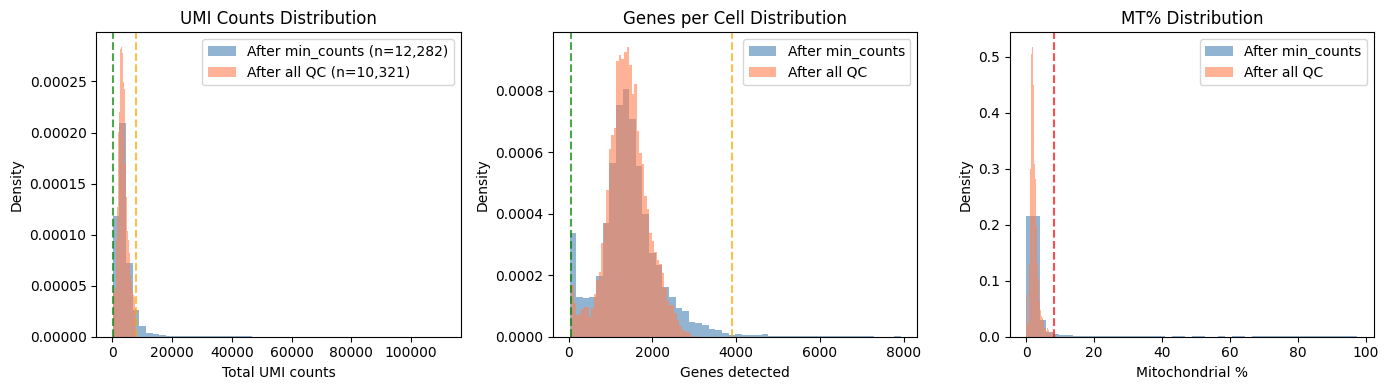


Metric                      After min_counts    After all QC      Removed
Number of cells                       12,282          10,321        1,961
Median UMI/cell                        3,438           3,407
Median genes/cell                      1,395           1,391
Median MT%                               2.1             2.0
Cells retained by QC                                   84.0%


In [17]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

prefilter_valid = (
    ~np.isnan(prefilter_counts) &
    ~np.isnan(prefilter_genes) &
    ~np.isnan(prefilter_mt) &
    (prefilter_counts >= MIN_COUNTS)
)

before_color = 'steelblue'
after_color = 'coral'
alpha = 0.6

# Plot 1: UMI counts distribution
axes[0].hist(prefilter_counts[prefilter_valid], bins=50, alpha=alpha, color=before_color, 
             label=f'After min_counts (n={prefilter_valid.sum():,})', density=True)
axes[0].hist(rna_adata.obs['total_counts'], bins=50, alpha=alpha, color=after_color,
             label=f'After all QC (n={rna_adata.n_obs:,})', density=True)
axes[0].set_xlabel('Total UMI counts')
axes[0].set_ylabel('Density')
axes[0].set_title('UMI Counts Distribution')
axes[0].legend()
axes[0].axvline(x=MIN_COUNTS, color='green', linestyle='--', alpha=0.7)
axes[0].axvline(x=MAX_COUNTS, color='orange', linestyle='--', alpha=0.7)

# Plot 2: Genes detected distribution
axes[1].hist(prefilter_genes[prefilter_valid], bins=50, alpha=alpha, color=before_color,
             label='After min_counts', density=True)
axes[1].hist(rna_adata.obs['n_genes_by_counts'], bins=50, alpha=alpha, color=after_color,
             label='After all QC', density=True)
axes[1].set_xlabel('Genes detected')
axes[1].set_ylabel('Density')
axes[1].set_title('Genes per Cell Distribution')
axes[1].legend()
axes[1].axvline(x=MIN_GENES, color='green', linestyle='--', alpha=0.7)
axes[1].axvline(x=MAX_GENES, color='orange', linestyle='--', alpha=0.7)

# Plot 3: MT% distribution
axes[2].hist(prefilter_mt[prefilter_valid], bins=50, alpha=alpha, color=before_color,
             label='After min_counts', density=True)
axes[2].hist(rna_adata.obs['pct_counts_mt'], bins=50, alpha=alpha, color=after_color,
             label='After all QC', density=True)
axes[2].set_xlabel('Mitochondrial %')
axes[2].set_ylabel('Density')
axes[2].set_title('MT% Distribution')
axes[2].legend()
axes[2].axvline(x=MAX_MT_PCT, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Summary statistics comparison
n_after_min_counts = prefilter_valid.sum()
n_after_all_qc = rna_adata.n_obs
n_removed_by_qc = n_after_min_counts - n_after_all_qc

print(f"\n{'Metric':<25} {'After min_counts':>18} {'After all QC':>15} {'Removed':>12}")
print("=" * 75)
print(f"{'Number of cells':<25} {n_after_min_counts:>18,} {n_after_all_qc:>15,} {n_removed_by_qc:>12,}")
print(f"{'Median UMI/cell':<25} {np.median(prefilter_counts[prefilter_valid]):>18,.0f} {rna_adata.obs['total_counts'].median():>15,.0f}")
print(f"{'Median genes/cell':<25} {np.median(prefilter_genes[prefilter_valid]):>18,.0f} {rna_adata.obs['n_genes_by_counts'].median():>15,.0f}")
print(f"{'Median MT%':<25} {np.median(prefilter_mt[prefilter_valid]):>18.1f} {rna_adata.obs['pct_counts_mt'].median():>15.1f}")
print(f"{'Cells retained by QC':<25} {'':<18} {100*n_after_all_qc/n_after_min_counts:>14.1f}%")

## Step 2a: Verify RNA is CD45+ Sorted

The RNA samples are supposed to be CD45+ sorted (FACS before sequencing). This verification checks that the data actually contains immune cells by examining:
- **Immune markers** (PTPRC/CD45, CD3E, MS4A1, CD68): Should be HIGH
- **Non-immune markers** (EPCAM, KRT8, INS): Should be LOW

If non-immune markers are high, the sample may not have been properly sorted or there may be contamination.

In [18]:
# === VERIFY RNA IS CD45+ SORTED (IMMUNE CELLS) ===
# The RNA data is supposed to be CD45+ sorted at sample prep
# This cell verifies the data actually contains immune cells

print("=" * 60)
print("VERIFYING RNA IS CD45+ SORTED (IMMUNE CELLS)")
print("=" * 60)

# Key immune markers to check
immune_markers = {
    'PTPRC': 'CD45 (pan-leukocyte)',
    'CD3E': 'T cells',
    'CD3D': 'T cells (alternative)',
    'MS4A1': 'B cells (CD20)',
    'CD79A': 'B cells',
    'CD68': 'Macrophages',
    'CD14': 'Monocytes',
    'FCGR3A': 'NK cells (CD16)',
    'NKG7': 'NK cells',
}

# Non-immune markers (should be LOW in CD45+ sorted data)
non_immune_markers = {
    'EPCAM': 'Epithelial',
    'KRT8': 'Epithelial (Cytokeratin 8)',
    'KRT18': 'Epithelial (Cytokeratin 18)',
    'PECAM1': 'Endothelial (CD31)',
    'COL1A1': 'Fibroblasts',
    'ACTA2': 'Smooth muscle (aSMA)',
    'INS': 'Beta cells (Insulin)',
    'GCG': 'Alpha cells (Glucagon)',
}

# Get expression matrix
X = rna_adata.X
if sparse.issparse(X):
    X_dense = X.toarray()
else:
    X_dense = X

gene_names = list(rna_adata.var_names)

print("\n--- IMMUNE MARKERS (should be HIGH) ---")
print(f"{'Marker':<10} {'Description':<25} {'% Detected':>12} {'Mean (detected)':>15}")
print("-" * 65)

immune_detected = []
for marker, desc in immune_markers.items():
    if marker in gene_names:
        idx = gene_names.index(marker)
        expr = X_dense[:, idx]
        pct_detected = 100 * (expr > 0).mean()
        mean_detected = expr[expr > 0].mean() if (expr > 0).any() else 0
        immune_detected.append(pct_detected)
        status = "✓" if pct_detected > 10 else "⚠️"
        print(f"{status} {marker:<8} {desc:<25} {pct_detected:>11.1f}% {mean_detected:>15.1f}")
    else:
        print(f"  {marker:<8} {desc:<25} {'NOT FOUND':>12}")

print("\n--- NON-IMMUNE MARKERS (should be LOW in CD45+ data) ---")
print(f"{'Marker':<10} {'Description':<25} {'% Detected':>12} {'Mean (detected)':>15}")
print("-" * 65)

non_immune_detected = []
for marker, desc in non_immune_markers.items():
    if marker in gene_names:
        idx = gene_names.index(marker)
        expr = X_dense[:, idx]
        pct_detected = 100 * (expr > 0).mean()
        mean_detected = expr[expr > 0].mean() if (expr > 0).any() else 0
        non_immune_detected.append(pct_detected)
        status = "✓" if pct_detected < 10 else "⚠️ HIGH"
        print(f"{status} {marker:<8} {desc:<25} {pct_detected:>11.1f}% {mean_detected:>15.1f}")
    else:
        print(f"  {marker:<8} {desc:<25} {'NOT FOUND':>12}")

# Summary assessment
print("\n" + "=" * 60)
print("ASSESSMENT")
print("=" * 60)

# Check PTPRC (CD45) specifically
if 'PTPRC' in gene_names:
    ptprc_idx = gene_names.index('PTPRC')
    ptprc_expr = X_dense[:, ptprc_idx]
    ptprc_pct = 100 * (ptprc_expr > 0).mean()
    
    if ptprc_pct > 50:
        print(f"✓ PTPRC (CD45) detected in {ptprc_pct:.1f}% of cells - GOOD")
        print("  Data appears to be properly CD45+ sorted")
    elif ptprc_pct > 20:
        print(f"⚠️ PTPRC (CD45) detected in only {ptprc_pct:.1f}% of cells - MODERATE")
        print("  This is lower than expected for CD45+ sorted data")
        print("  Note: CD45 can have low detection in scRNAseq due to dropout")
    else:
        print(f"⚠️ PTPRC (CD45) detected in only {ptprc_pct:.1f}% of cells - LOW")
        print("  Verify that samples were actually CD45+ sorted")
else:
    print("⚠️ PTPRC not found in gene list")

# Check for contamination
if non_immune_detected:
    max_non_immune = max(non_immune_detected)
    if max_non_immune > 20:
        print(f"\n⚠️ WARNING: Non-immune marker detected in {max_non_immune:.1f}% of cells")
        print("  This may indicate contamination with non-immune cells")
        print("  Consider additional filtering if integration quality is poor")
    else:
        print(f"\n✓ Non-immune markers are low (<20%) - minimal contamination")

# Per-tissue breakdown for PTPRC
if 'PTPRC' in gene_names:
    print("\n--- PTPRC (CD45) by Tissue ---")
    for tissue in rna_adata.obs['Tissue'].unique():
        mask = rna_adata.obs['Tissue'] == tissue
        tissue_expr = X_dense[mask, ptprc_idx]
        tissue_pct = 100 * (tissue_expr > 0).mean()
        print(f"  {tissue}: {tissue_pct:.1f}% CD45+")

print("=" * 60)

VERIFYING RNA IS CD45+ SORTED (IMMUNE CELLS)

--- IMMUNE MARKERS (should be HIGH) ---
Marker     Description                 % Detected Mean (detected)
-----------------------------------------------------------------
✓ PTPRC    CD45 (pan-leukocyte)             86.2%             3.7
✓ CD3E     T cells                          48.8%             2.9
✓ CD3D     T cells (alternative)            33.5%             1.9
✓ MS4A1    B cells (CD20)                   34.4%             3.8
✓ CD79A    B cells                          37.1%             6.1
⚠️ CD68     Macrophages                       6.0%             1.9
⚠️ CD14     Monocytes                         1.3%             2.5
⚠️ FCGR3A   NK cells (CD16)                   0.4%             1.4
⚠️ NKG7     NK cells                          2.2%             2.0

--- NON-IMMUNE MARKERS (should be LOW in CD45+ data) ---
Marker     Description                 % Detected Mean (detected)
------------------------------------------------------------

## Step 2b: Log-Normalized RNA for Visualization

Create a log-normalized copy of RNA data **for visualization only**.

**Why this is separate from integration:**
- Integration (Step 4+) uses detection-aware normalization to create comparable RNA/protein distributions
- Visualization needs standard log-normalization for interpretable expression levels in plots
- These serve different purposes and should not be conflated

In [19]:
# Log-normalized RNA for VISUALIZATION ONLY
# This is NOT used for integration - integration uses detection-aware normalized arrays

rna_adata_lognorm = rna_adata.copy()
sc.pp.normalize_total(rna_adata_lognorm, target_sum=1e4)
sc.pp.log1p(rna_adata_lognorm)

# Alias for convenience in downstream annotation cells
rna_adata_active = rna_adata_lognorm

print(f"Log-normalized RNA for visualization: {rna_adata_lognorm.shape}")
print(f"\nThis will be used for:")
print(f"  - Coloring UMAPs by gene expression")
print(f"  - Dotplots of marker genes")
print(f"  - Cell type annotation")
print(f"\nIntegration uses separate detection-aware normalized arrays (Step 4).")

Log-normalized RNA for visualization: (10321, 20550)

This will be used for:
  - Coloring UMAPs by gene expression
  - Dotplots of marker genes
  - Cell type annotation

Integration uses separate detection-aware normalized arrays (Step 4).


## Save Preprocessed Data

Save filtered and processed data for use in subsequent notebooks.
This creates checkpoint files that allow notebooks to be run independently.

In [21]:
import os
import json
from datetime import datetime
# Create results directory
results_dir = 'results/1_preprocessing'
os.makedirs(results_dir, exist_ok=True)

# Save protein AnnData (CODEX)
protein_adata.write_h5ad(f'{results_dir}/protein_adata.h5ad')
print(f"Saved protein_adata: {protein_adata.shape}")

# Save RNA AnnData (filtered, raw counts)
rna_adata.write_h5ad(f'{results_dir}/rna_adata.h5ad')
print(f"Saved rna_adata: {rna_adata.shape}")

# Save log-normalized RNA (for visualization)
rna_adata_lognorm.write_h5ad(f'{results_dir}/rna_adata_lognorm.h5ad')
print(f"Saved rna_adata_lognorm: {rna_adata_lognorm.shape}")

# # Save preprocessing parameters as JSON
# params = {
#     'timestamp': datetime.now().isoformat(),
#     'rna_filtering': {
#         'min_counts': MIN_COUNTS,
#         'max_counts': MAX_COUNTS,
#         'min_genes': MIN_GENES,
#         'max_genes': MAX_GENES,
#         'max_mt_pct': MAX_MT_PCT
#     },
#     'data_shapes': {
#         'protein_cells': protein_adata.n_obs,
#         'protein_markers': protein_adata.n_vars,
#         'rna_cells': rna_adata.n_obs,
#         'rna_genes': rna_adata.n_vars
#     }
# }

# with open(f'{results_dir}/preprocessing_params.json', 'w') as f:
#     json.dump(params, f, indent=2)

# print(f"\nAll outputs saved to {results_dir}/")
# print(f"  - protein_adata.h5ad")
# print(f"  - rna_adata.h5ad") 
# print(f"  - rna_adata_lognorm.h5ad")
# print(f"  - preprocessing_params.json")
# print(f"\nRun 2_integration.ipynb next.")

Saved protein_adata: (1679455, 23)
Saved rna_adata: (10321, 20550)
Saved rna_adata_lognorm: (10321, 20550)
